In [32]:
##Similar to simple_automation, but some key differences:
## - Given every load point, quantity and load
## - Predict dump point
## - Plot actual dump points versus predicted dump points
## - Should use vicinity of previous dump locations

In [33]:
import dataloader
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import geopy.distance
from schemas import Trip
import datetime as dt
import ipyleaflet as L
from ipywidgets import Layout
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import datetime
from tqdm import tqdm

In [34]:
#Day we want to look at
trip = dataloader.TripsLoader('03-11-2022')

Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  

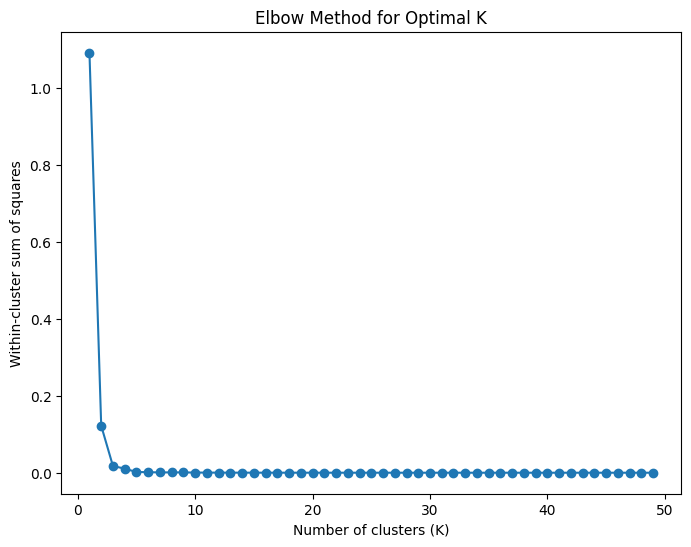

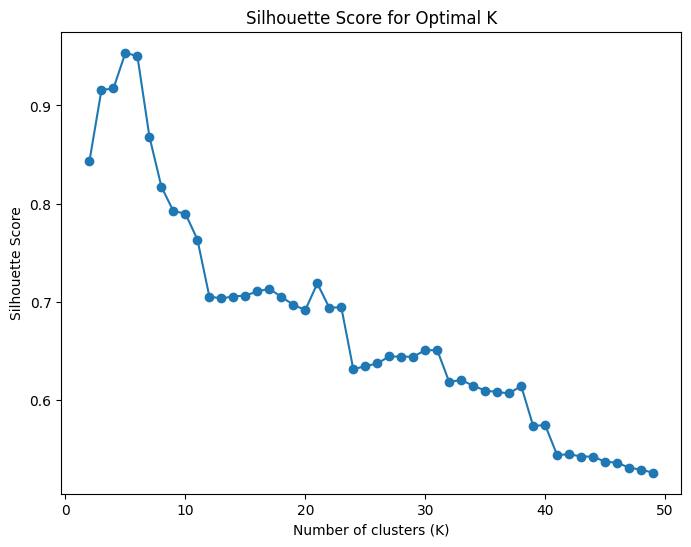

In [35]:
#K-means
#Get all dump positions for a given day
trip_day_before = dataloader.TripsLoader('03-10-2022')
all_dump_positions_for_day_before = []

for machine_number in trip_day_before._machines.keys():
    temp_machine = trip_day_before._machines[machine_number]
    all_dump_positions_for_day_before.append([trip.dump_latlon for trip in temp_machine.trips])

all_dump_positions_for_day_before =  [item for sublist in all_dump_positions_for_day_before for item in sublist]

# Assuming 'coordinates' is list of tuples [(lat1, lon1), (lat2, lon2), ...]
coordinates_array = np.array(all_dump_positions_for_day_before)

inertia = []
K_range = range(1, 50)  # You can adjust the range as needed

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(coordinates_array)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow Method for Optimal K')
plt.show()

silhouette_scores = []

for k in K_range:
    if k==1:
        silhouette_scores.append(None)
    
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(coordinates_array)
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(coordinates_array, labels))

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

In [36]:
# Set the optimal K value you found from the elbow method and silhouette score analysis
optimal_K = 30

# Fit the KMeans model with the optimal K value
kmeans = KMeans(n_clusters=optimal_K, random_state=42, n_init='auto')
kmeans.fit(coordinates_array)

# Get the coordinates of the cluster centers for the optimal K value
cluster_centers = kmeans.cluster_centers_

In [37]:
# Create a map centered at the mean of all coordinates, with heatmap
map_center = np.mean(coordinates_array, axis=0)
m = L.Map(center=(map_center[0], map_center[1]), zoom=10)

# Add markers for each cluster center to the map
for center in cluster_centers:
    marker = L.Marker(location=(center[0], center[1]))
    m.add_layer(marker)
heatmap = L.Heatmap(locations=all_dump_positions_for_day_before,radius=20)
m.add_layer(heatmap)

# Display the map
m

Map(center=[59.960285839724534, 10.36365155826993], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [38]:
#Machine we want to look at
pred_dict_error = {}
for machine_nb in tqdm(trip._machines.keys()):
    some_machine = trip._machines[machine_nb]
    for trips in some_machine.trips:    
        
        trip_speeds = []
        trip_dists = []
        time_keeper = []
        time_of_dump = trips.positions[0].timestamp # Just give it some value
        predicted_dump_time = None
        predicted_dump_latlon = None
        entering_working_area = []
        exiting_working_area = []
        initial_lat_lon = (trips.positions[0].lat, trips.positions[0].lon)
        in_working_area = False
        predicted_dump = False

        for coord in cluster_centers:
            if geopy.distance.geodesic(coord, initial_lat_lon).m < 100:
                in_working_area = True

        actual_dump_lat_lon = trips.dump_latlon

        for i in range(len(trips.positions[1:])):
            current_time = trips.positions[i].timestamp
            prev_time = trips.positions[i-1].timestamp

            current_lat_lon = (trips.positions[i].lat,trips.positions[i].lon)

            if current_lat_lon == actual_dump_lat_lon:
                time_of_dump = current_time

            prev_lat_lon = (trips.positions[i-1].lat,trips.positions[i-1].lon)

            seconds_gone = (current_time.to_pydatetime()-prev_time.to_pydatetime()).total_seconds()
            meters_driven = geopy.distance.geodesic(prev_lat_lon, current_lat_lon).m

            
            if seconds_gone > 0:
                speed_kmh = (meters_driven/seconds_gone)*3.6
                trip_speeds.append(speed_kmh)
                trip_dists.append(meters_driven/1000)
                time_keeper.append(current_time)

                currently_in_working_area = False
                for coord in cluster_centers:
                    if geopy.distance.geodesic(coord, current_lat_lon).m < 100:
                        currently_in_working_area = True
                    
                    
                if not in_working_area and currently_in_working_area:
                    entering_working_area.append(current_time)
                    in_working_area = True
                elif in_working_area and not currently_in_working_area:
                    exiting_working_area.append(current_time)
                    in_working_area = False
                
                #Demands to predict dump point
                if in_working_area and speed_kmh < 5 and sum(trip_dists)>0.2 and not predicted_dump: #want to add cumsum last 2 ish minutes to be lower than 500m for example
                    last_min_start = current_time-timedelta(minutes=1)
                    index_start_minute = None
                    for i, ts in enumerate(time_keeper):
                        if ts >= last_min_start:
                            index_start_minute = i
                            break
                    sum_over_last_minute = np.sum(trip_speeds[index_start_minute:])
                    if sum_over_last_minute < 200:
                        predicted_dump_latlon = current_lat_lon
                        predicted_dump_time = current_time
                        pred_dict_error[trips.trip_id] = {"seconds_passed": (trips.positions[-1].timestamp-trips.positions[0].timestamp).total_seconds(),
                                                        "second_error": np.abs((time_of_dump-predicted_dump_time).total_seconds()),
                                                        "meter_driven": trips.length*1000,
                                                        "meter_error": geopy.distance.geodesic(predicted_dump_latlon, actual_dump_lat_lon).m}
                        predicted_dump = True
        
        # Plots, not wanted when a lot of data
        # Create subplots with 2 rows and 1 column
        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

        # Add the first line plot to the first subplot
        fig.add_trace(go.Scatter(x=time_keeper, y=trip_speeds, mode='lines', name='Speed'), row=1, col=1)
        fig.add_trace(go.Scatter(x=[time_of_dump], y=[0], mode='markers', marker=dict(symbol='cross', size=10, color='red'), name='Dump actual'), row=1, col=1)
        fig.add_trace(go.Scatter(x=[predicted_dump_time], y=[0], mode='markers', marker=dict(symbol='star', size=10, color='red'), name='Dump predicted'), row=1, col=1)
        fig.add_trace(go.Scatter(x=entering_working_area, y=[0 for e in entering_working_area], mode='markers', marker=dict(symbol='cross', size=10, color='green'), name='Entering working area'), row=1, col=1)
        fig.add_trace(go.Scatter(x=exiting_working_area, y=[0 for e in exiting_working_area], mode='markers', marker=dict(symbol='cross', size=10, color='yellow'), name='Exiting working area'), row=1, col=1)

        # Add the second line plot to the second subplot
        fig.add_trace(go.Scatter(x=time_keeper, y=np.cumsum(trip_dists), mode='lines', name='Cumulative distance'), row=2, col=1)
        fig.add_trace(go.Scatter(x=[time_of_dump], y=[0], mode='markers', marker=dict(symbol='cross', size=10, color='red'), name='Dump actual'), row=2, col=1)
        fig.add_trace(go.Scatter(x=[predicted_dump_time], y=[0], mode='markers', marker=dict(symbol='star', size=10, color='red'), name='Dump predicted'), row=2, col=1)
        fig.add_trace(go.Scatter(x=entering_working_area, y=[0 for e in entering_working_area], mode='markers', marker=dict(symbol='cross', size=10, color='green'), name='Entering working area'), row=2, col=1)
        fig.add_trace(go.Scatter(x=exiting_working_area, y=[0 for e in exiting_working_area], mode='markers', marker=dict(symbol='cross', size=10, color='yellow'), name='Exiting working area'), row=2, col=1)


        # Update layout settings for both subplots
        fig.update_layout(title=str('Subplots of Speeds and cumulative distance, trip ID: '+ trips.trip_id),
                        xaxis_title='Timestamp',
                        showlegend=True)

        # Show the plot
        fig.show()
        try:
            m = L.Map(layout=Layout(width='60%', height='700px'), center=[59.95, 10.3])
            line = L.Polyline(locations=[(pos.lat, pos.lon) for pos in trips.positions], color="blue" ,fill=False)
            start_point = L.CircleMarker(location=(trips.positions[0].lat,trips.positions[0].lon), color="green")
            end_point = L.CircleMarker(location=(trips.positions[-1].lat,trips.positions[-1].lon), color="orange")
            actual_dump_point = L.CircleMarker(location=actual_dump_lat_lon, color="red")
            predicted_dump_point = L.Marker(location=predicted_dump_latlon, draggable=False)
            m.add_layer(line)
            m.add_layer(start_point)
            m.add_layer(end_point)
            m.add_layer(actual_dump_point)
            m.add_layer(predicted_dump_point)
            display(m)
        except:
            pass

  0%|          | 0/23 [00:00<?, ?it/s]

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

  4%|▍         | 1/23 [00:32<12:04, 32.92s/it]

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Map(center=[59.95, 10.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

  4%|▍         | 1/23 [00:54<20:05, 54.79s/it]


KeyboardInterrupt: 

In [ ]:
#Want to define some metrics, such as how many meter we miss by average and how much time we miss by average
pred_dict_error

{'622ae5dbeb2cc6000037c359': {'seconds_passed': 1494.994,
  'second_error': 0.0,
  'meter_driven': 11303.402728975536,
  'meter_error': 0.0},
 '622aebb5c5acbc00006e7cbe': {'seconds_passed': 1706.999,
  'second_error': 871.998,
  'meter_driven': 11442.27221819106,
  'meter_error': 114.30443541252443},
 '622af2676eaee30000b21c1a': {'seconds_passed': 2920.001,
  'second_error': 953.01,
  'meter_driven': 12125.942249729407,
  'meter_error': 2.0580344469098373},
 '622afdd2deeab800004c3acc': {'seconds_passed': 1421.01,
  'second_error': 494.998,
  'meter_driven': 11119.106988653375,
  'meter_error': 24.123452934691628},
 '622b0366a28a13000045df78': {'seconds_passed': 1720.0,
  'second_error': 730.991,
  'meter_driven': 11286.631176583289,
  'meter_error': 94.52193314204158},
 '622b0a3420382500004d3dbc': {'seconds_passed': 1515.994,
  'second_error': 851.0,
  'meter_driven': 11215.31596841044,
  'meter_error': 17.56746460489564},
 '622b103caf03e20000350283': {'seconds_passed': 1446.006,
  'se

In [ ]:
import pandas as pd

df = pd.DataFrame(pred_dict_error).T

In [ ]:
df["second_error"]

622ae5dbeb2cc6000037c359       0.000
622aebb5c5acbc00006e7cbe     871.998
622af2676eaee30000b21c1a     953.010
622afdd2deeab800004c3acc     494.998
622b0366a28a13000045df78     730.991
                              ...   
622b8b40089644000027584a    1373.999
622b94bb7fe40d0000f7d3fd    1130.004
622ba72d509d56000096416a     328.002
622baa02ea4c4e00007967cb     367.999
622babc2df2b0e0000589155     469.000
Name: second_error, Length: 511, dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 511 entries, 622ae5dbeb2cc6000037c359 to 622babc2df2b0e0000589155
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   seconds_passed  511 non-null    float64
 1   second_error    511 non-null    float64
 2   meter_driven    511 non-null    float64
 3   meter_error     511 non-null    float64
dtypes: float64(4)
memory usage: 36.1+ KB


array([[<Axes: title={'center': 'seconds_passed'}>,
        <Axes: title={'center': 'second_error'}>],
       [<Axes: title={'center': 'meter_driven'}>,
        <Axes: title={'center': 'meter_error'}>]], dtype=object)

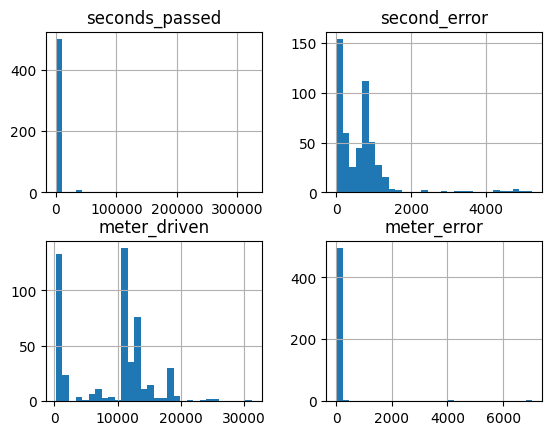

In [ ]:
df

seconds_passed  second_error  meter_driven  \
622ae5dbeb2cc6000037c359        1494.994         0.000  11303.402729   
622aebb5c5acbc00006e7cbe        1706.999       871.998  11442.272218   
622af2676eaee30000b21c1a        2920.001       953.010  12125.942250   
622afdd2deeab800004c3acc        1421.010       494.998  11119.106989   
622b0366a28a13000045df78        1720.000       730.991  11286.631177   
...                                  ...           ...           ...   
622b8b40089644000027584a        2419.997      1373.999  18370.163889   
622b94bb7fe40d0000f7d3fd        4578.997      1130.004  18883.825754   
622ba72d509d56000096416a         366.003       328.002    411.845171   
622baa02ea4c4e00007967cb         404.999       367.999    490.053624   
622babc2df2b0e0000589155        1236.001       469.000   9201.654561   

                          meter_error  
622ae5dbeb2cc6000037c359     0.000000  
622aebb5c5acbc00006e7cbe   114.304435  
622af2676eaee30000b21c1a     2.058034  
622afdd2deeab800004c3acc    24.123453  
622b0366a28a13000045df78    94.521933  
...                               ...  
622b8b40089644000027584a   114.645101  
622b94bb7fe40d0000f7d3fd    46.111853  
622ba72d509d56000096416a    24.547145  
622baa02ea4c4e00007967cb    32.146830  
622babc2df2b0e0000589155    39.598809  

[511 rows x 4 columns]

In [ ]:
df["seconds_percentage_error"] = (df["second_error"]/df["seconds_passed"])*100
df["meters_percentage_error"] = (df["meter_error"]/df["meter_driven"])*100

array([[<Axes: title={'center': 'seconds_passed'}>,
        <Axes: title={'center': 'second_error'}>],
       [<Axes: title={'center': 'meter_driven'}>,
        <Axes: title={'center': 'meter_error'}>],
       [<Axes: title={'center': 'seconds_percentage_error'}>,
        <Axes: title={'center': 'meters_percentage_error'}>]],
      dtype=object)

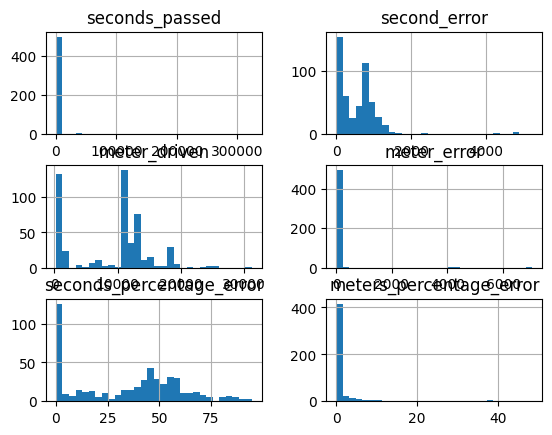

In [ ]:
df.hist(bins=30)